In [0]:
pip install deap

     |████████████████████████████████| 163kB 2.7MB/s 


In [0]:
pip install scoop

     |████████████████████████████████| 604kB 2.8MB/s 
  Created wheel for scoop: filename=scoop-0.7.1.1-cp36-none-any.whl size=72125 sha256=9419c1d061b595cd6587d32a6960a3f074143ad6f82d31bb465b4154669932e9
  Stored in directory: /root/.cache/pip/wheels/9e/54/e5/5105f5602fdc4a1fbc911d786ca1114ee8f870ac00752d302f
Successfully built scoop


In [0]:
from sklearn.datasets import load_breast_cancer
cancer_dataset_dictionary = load_breast_cancer()

In [0]:
cancer_dataset_dictionary

{'DESCR': '.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry \n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        largest values) of these features were computed for each image,\n        resulting in 30 features.  For

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
dfData = pd.DataFrame(np.c_[cancer_dataset_dictionary['data'],cancer_dataset_dictionary['target']],
             columns = np.append(cancer_dataset_dictionary['feature_names'], ['target']))

In [0]:
dfData.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [0]:
X = dfData.drop(['target'], axis = 1)
X.head(6)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [0]:
y = dfData['target']
y.head(6)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: target, dtype: float64

In [0]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from deap import creator, base, tools, algorithms
from scoop import futures
import random
import numpy
from scipy import interpolate
import matplotlib.pyplot as plt

le = LabelEncoder()
le.fit(dfData['target'])
allClasses = le.transform(dfData['target'])
allFeatures = dfData.drop(['target'], axis=1)


X_trainAndTest, X_validation, y_trainAndTest, y_validation = train_test_split(allFeatures, allClasses, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_trainAndTest, y_trainAndTest, test_size=0.20, random_state=42)


def getFitness(individual, X_train, X_test, y_train, y_test):

	cols = [index for index in range(len(individual)) if individual[index] == 0]
	X_trainParsed = X_train.drop(X_train.columns[cols], axis=1)
	X_trainOhFeatures = pd.get_dummies(X_trainParsed)
	X_testParsed = X_test.drop(X_test.columns[cols], axis=1)
	X_testOhFeatures = pd.get_dummies(X_testParsed)

	sharedFeatures = set(X_trainOhFeatures.columns) & set(X_testOhFeatures.columns)
	removeFromTrain = set(X_trainOhFeatures.columns) - sharedFeatures
	removeFromTest = set(X_testOhFeatures.columns) - sharedFeatures
	X_trainOhFeatures = X_trainOhFeatures.drop(list(removeFromTrain), axis=1)
	X_testOhFeatures = X_testOhFeatures.drop(list(removeFromTest), axis=1)

	clf = LogisticRegression()
	clf.fit(X_trainOhFeatures, y_train)
	predictions = clf.predict(X_testOhFeatures)
	accuracy = accuracy_score(y_test, predictions)

	return (accuracy,)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(dfData.columns) - 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


toolbox.register("evaluate", getFitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)



def getHof():

	numPop = 100
	numGen = 10
	pop = toolbox.population(n=numPop)
	hof = tools.HallOfFame(numPop * numGen)
	stats = tools.Statistics(lambda ind: ind.fitness.values)
	stats.register("avg", numpy.mean)
	stats.register("std", numpy.std)
	stats.register("min", numpy.min)
	stats.register("max", numpy.max)

	pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=numGen, stats=stats, halloffame=hof, verbose=True)

	return hof

def getMetrics(hof):

	percentileList = [i / (len(hof) - 1) for i in range(len(hof))]
	
	testAccuracyList = []
	validationAccuracyList = []
	individualList = []
	for individual in hof:
		testAccuracy = individual.fitness.values
		validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
		testAccuracyList.append(testAccuracy[0])
		validationAccuracyList.append(validationAccuracy[0])
		individualList.append(individual)
	testAccuracyList.reverse()
	validationAccuracyList.reverse()
	return testAccuracyList, validationAccuracyList, individualList, percentileList


if __name__ == '__main__':

	individual = [1 for i in range(len(allFeatures.columns))]
	testAccuracy = getFitness(individual, X_train, X_test, y_train, y_test)
	validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
	print('\nTest accuracy with all features: \t' + str(testAccuracy[0]))
	print('Validation accuracy with all features: \t' + str(validationAccuracy[0]) + '\n')

	hof = getHof()
	testAccuracyList, validationAccuracyList, individualList, percentileList = getMetrics(hof)

	maxValAccSubsetIndicies = [index for index in range(len(validationAccuracyList)) if validationAccuracyList[index] == max(validationAccuracyList)]
	maxValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
	maxValSubsets = [[list(allFeatures)[index] for index in range(len(individual)) if individual[index] == 1] for individual in maxValIndividuals]

	print('\n---Optimal Feature Subset(s)---\n')
	for index in range(len(maxValAccSubsetIndicies)):
		print('Percentile: \t\t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
		print('Validation Accuracy: \t\t' + str(validationAccuracyList[maxValAccSubsetIndicies[index]]))
		print('Individual: \t' + str(maxValIndividuals[index]))
		print('Number Features In Subset: \t' + str(len(maxValSubsets[index])))
		print('Feature Subset: ' + str(maxValSubsets[index]))

	

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MS


Test accuracy with all features: 	0.9340659340659341
Validation accuracy with all features: 	0.9649122807017544



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


gen	nevals	avg     	std      	min     	max     
0  	100   	0.942637	0.0205926	0.791209	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


1  	69    	0.95    	0.00911161	0.923077	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


2  	65    	0.953297	0.00751362	0.923077	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


3  	61    	0.952637	0.00902103	0.923077	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


4  	60    	0.955275	0.00935745	0.901099	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


5  	55    	0.957253	0.00863809	0.934066	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


6  	59    	0.959341	0.00814967	0.923077	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


7  	56    	0.959341	0.00872226	0.923077	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


8  	61    	0.959121	0.00933484	0.923077	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


9  	64    	0.961319	0.00843796	0.923077	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


10 	62    	0.962637	0.00761341	0.923077	0.967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---Optimal Feature Subset(s)---

Percentile: 			0.37628865979381443
Validation Accuracy: 		1.0
Individual: 	[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Number Features In Subset: 	14
Feature Subset: ['mean texture', 'mean perimeter', 'mean concave points', 'smoothness error', 'concavity error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst compactness', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Percentile: 			0.9089347079037801
Validation Accuracy: 		1.0
Individual: 	[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]
Number Features In Subset: 	18
Feature Subset: ['mean radius', 'mean texture', 'mean perimeter', 'mean smoothness', 'mean fractal dimension', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'worst texture', 'worst per

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
X_new=X[['mean radius', 'mean texture', 'mean perimeter', 'mean smoothness', 'mean fractal dimension', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'worst texture', 'worst perimeter', 'worst area', 'worst compactness', 'worst concave points', 'worst fractal dimension']]

In [0]:
X_new.head()

,mean radius,mean texture,mean perimeter,mean smoothness,mean fractal dimension,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,worst texture,worst perimeter,worst area,worst compactness,worst concave points,worst fractal dimension
0,17.99,10.38,122.80,0.11840,0.07871,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,17.33,184.60,2019.0,0.6656,0.2654,0.11890
1,20.57,17.77,132.90,0.08474,0.05667,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,23.41,158.80,1956.0,0.1866,0.1860,0.08902
2,19.69,21.25,130.00,0.10960,0.05999,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,25.53,152.50,1709.0,0.4245,0.2430,0.08758
3,11.42,20.38,77.58,0.14250,0.09744,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,26.50,98.87,567.7,0.8663,0.2575,0.17300
4,20.29,14.34,135.10,0.10030,0.05883,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,16.67,152.20,1575.0,0.2050,0.1625,0.07678


In [0]:
y

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
564    0.0
565    0.0
566    0.0
567    0.0
568    1.0
Name: target, Length: 569, dtype: float64

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state= 5)

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [0]:
from sklearn.svm import SVC                                         #Implementing SVC() classifier without normalization
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)
y_pred_scv = svc_classifier.predict(X_test)
accuracy_score(y_test, y_pred_scv)

0.9473684210526315

In [0]:
svc_classifier2 = SVC()                                             #Implementing SVC() classifier with normalization
svc_classifier2.fit(X_train_sc, y_train)
y_pred_svc_sc = svc_classifier2.predict(X_test_sc)
accuracy_score(y_test, y_pred_svc_sc)

0.9736842105263158

In [0]:
# Logistic Regression without normalization
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(random_state = 51, penalty = 'l2')
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
accuracy_score(y_test, y_pred_lr)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9649122807017544

In [0]:
# Logistic Regression with normalization
lr_classifier2 = LogisticRegression(random_state = 51, penalty = 'l2')
lr_classifier2.fit(X_train_sc, y_train)
y_pred_lr_sc = lr_classifier.predict(X_test_sc)
accuracy_score(y_test, y_pred_lr_sc)

0.5087719298245614

In [0]:
# K – Nearest Neighbor Classifier without normalization
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
accuracy_score(y_test, y_pred_knn)

0.9385964912280702

In [0]:
# KNN with normalization
knn_classifier2 = KNeighborsClassifier(n_neighbors = 5)
y_pred_knn_sc = knn_classifier.predict(X_test_sc)
accuracy_score(y_test, y_pred_knn_sc)

0.5789473684210527

In [0]:
# Naive Bayes Classifier without normalization
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
accuracy_score(y_test, y_pred_nb)

0.9649122807017544

In [0]:
# With normalization
nb_classifier2 = GaussianNB()
nb_classifier2.fit(X_train_sc, y_train)
y_pred_nb_sc = nb_classifier2.predict(X_test_sc)
accuracy_score(y_test, y_pred_nb_sc)

0.9649122807017544

In [0]:
# Decision Tree Classifier without normalization
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 51)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
accuracy_score(y_test, y_pred_dt)

0.9473684210526315

In [0]:
# Decision Tree Classifier with normalization
dt_classifier2 = DecisionTreeClassifier(criterion = 'entropy', random_state = 51)
dt_classifier2.fit(X_train_sc, y_train)
y_pred_dt_sc = dt_classifier.predict(X_test_sc)
accuracy_score(y_test, y_pred_dt_sc)

0.9298245614035088

In [0]:
# Random Forest Classifier without normalization
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 51)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.9736842105263158

In [0]:
# Random Forest Classifier with normalization
rf_classifier2 = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 51)
rf_classifier2.fit(X_train_sc, y_train)
y_pred_rf_sc = rf_classifier.predict(X_test_sc)
accuracy_score(y_test, y_pred_rf_sc)

0.5789473684210527

In [0]:
print(classification_report(y_test, y_pred_svc_sc))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97        48
         1.0       0.97      0.98      0.98        66

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



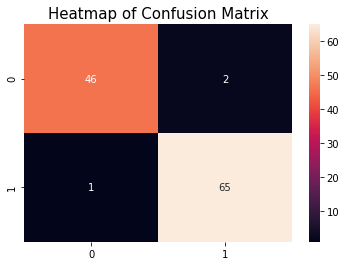

In [0]:
cm = confusion_matrix(y_test, y_pred_svc_sc)
plt.title('Heatmap of Confusion Matrix', fontsize = 15)
sns.heatmap(cm, annot = True)
plt.show()